In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spln
import metropolishastings as mh
from state import State
import seaborn as sns

We use the Metropolis-Hastings algorithm to perform Gibbs sampling on a bivariate normal random variable:
$$N\left(
\left(\begin{array}{c}\mu_X\\\mu_Y \end{array}\right), 
\left(\begin{array}{cc}\sigma_X^2 & \rho \sigma_X \sigma_Y \\ \rho \sigma_X \sigma_Y & \sigma_Y^2\end{array} \right)\right).$$
In this case, all draws will be accepted. 


First, we define a function that draws from the marginal distribution

In [2]:
def draw_marginals(mu_X, mu_Y, sigma_X, sigma_Y, rho, given, draw_from_X):
    """Draws from the marginals of the bivariate normal distribution.
    
    :param mu_X: location parameter for X
    :type mu_X: float
    
    :param mu_Y: location parameter for Y
    :type mu_Y: float
    
    :param sigma_X: scale parameter for X
    :type sigma_X: float
    
    :param sigma_Y: scale parameter for Y
    :type sigma_Y: float
    
    :param rho: correlation coefficient
    :type rho: float
    
    :param given: value of the given variable
    :type given: float
    
    :param draw_from_X: if True, draw from X given Y. 
        If False, draw from Y given X.
    :type draw_from_Y: bool
    """
    if draw_from_X:
        mean = mu_X + sigma_X * rho * (given - mu_Y) / sigma_Y
        var = (1 - rho * rho) * sigma_X * sigma_X
    else:
        mean = mu_Y + sigma_Y * rho * (given - mu_X) / sigma_X
        var = (1 - rho * rho) * sigma_Y * sigma_Y

    draw = np.random.normal(loc=mean, scale = np.sqrt(var))
    return draw

Here, the state is a vector with the values of the parameters.

In [3]:
class normal_draws(State):
    def __init__(
        self, 
        xy,
        draw_from_X,
        draw_from_Y
    ):
        """Constructor
        """
        self.xy = xy
        self.draw_from_X = draw_from_X
        self.draw_from_Y = draw_from_Y
   
    def indicators(self):
        """The indicators are the parameters of interest, generated 
        by each draw. In this case, the indicators are the states 
        themselves.

        :return: array of indicators
        :rtype: numpy.array()
        """
        return self.xy

    def next_state(self):
        """
        We select randomly a dimension, and draw from the marginal, 
        conditional on the over value. 
        Here, the transition probability are irrelevant.
        
        :return: state, logpij, logpji
        :rtype: State, float, float


        """
        # Decide if we draw from X or from Y
        generate_X = np.random.uniform() <= 0.5
        
        if generate_X:
            y_value = self.xy[1]
            x_value = self.draw_from_X(y_value)
        else:
            x_value = self.xy[0]
            y_value = self.draw_from_Y(x_value)
            
        next_state = normal_draws(
            np.array([x_value, y_value]),
            self.draw_from_X,
            self.draw_from_Y,
        )
        return (
            next_state, 
            0, 
            0,
        )
    
    def logweight(self):
        """For Gibbs sampling, the weight are irrelevant, as all 
        draws are accepted. We return 0. 

        :return: log of the weight
        :rtype: float
        """
        
        return 0



Parameter of the target distribution

In [4]:
mu_X = 0
mu_Y = 2
sigma_X = 2
sigma_Y = 1
rho = 0.99

In [5]:
def draw_from_X(y):
    return draw_marginals(mu_X, mu_Y, sigma_X, sigma_Y, rho, y, True)

In [6]:
def draw_from_Y(x):
    return draw_marginals(mu_X, mu_Y, sigma_X, sigma_Y, rho, x, False)

We start five independent Markov processes, each starting from a different state.

In [7]:
initialStates = [
    normal_draws(
        np.array([mu_X, mu_Y]), 
        draw_from_X,
        draw_from_Y,
    ),
    normal_draws(
        np.array([mu_X - 2 * sigma_X, mu_Y - 2 * sigma_Y]), 
        draw_from_X,
        draw_from_Y,
    ),
    normal_draws(
        np.array([mu_X + 2 * sigma_X, mu_Y + 2 * sigma_Y]), 
        draw_from_X,
        draw_from_Y,
    ),
    normal_draws(
        np.array([mu_X - 2 * sigma_X, mu_Y + 2 * sigma_Y]), 
        draw_from_X,
        draw_from_Y,
    ),
    normal_draws(
        np.array([mu_X + 2 * sigma_X, mu_Y - 2 * sigma_Y]), 
        draw_from_X,
        draw_from_Y,
    ),

]

In [8]:
numberOfDraws = 100000
maxNumberOfIterations = 10

We apply the MH algorithm.

In [9]:
draws, estimates, convergence, numberOfTrials = mh.MetropolisHastings(
    initialStates,
    numberOfDraws,
    maxNumberOfIterations,
)

Warmup


100%|██████████| 100000/100000 [00:01<00:00, 78095.27it/s]


Trial 0 with 100000 draws


100%|██████████| 100000/100000 [00:01<00:00, 75655.67it/s]


Generated draws: (5, 100000, 2)
Success rate: 1.0
Success rate: 1.0
Success rate: 1.0
Success rate: 1.0
Success rate: 1.0
Potential scale reduction: [1.00487063 1.00487853]
    should be at most 1.1
Effective number of simulation draws: [1170.46240976 1169.31076715]
    should be at least 50


The sample mean of X and Y

In [10]:
estimates

array([0.03450343, 2.01695361])

Compared to the requested ones

In [11]:
mu_X, mu_Y

(0, 2)

The sample standard deviation of X and Y

In [12]:
for d in draws:
    print(np.std(d))

2.0194754856203088
1.009824908532251


Compared to the requested one

In [13]:
sigma_X, sigma_Y

(2, 1)

And the correlation coefficient

In [14]:
np.corrcoef(draws)

array([[1.        , 0.99019756],
       [0.99019756, 1.        ]])

Compared to the requested one

In [15]:
rho

0.99

We plot the draws

In [16]:
df = pd.DataFrame({'X': draws[0], 'Y': draws[1]})
df

,X,Y
0,1.544756,2.699303
1,1.109918,2.699303
2,1.477945,2.699303
3,1.477945,2.849537
4,1.583313,2.849537
...,...,...
499995,3.679213,3.886368
499996,3.502285,3.886368
499997,3.502285,3.847118
499998,3.396552,3.847118


In [17]:
minimum_value = draws.min()
minimum_value

-8.091269225357014

In [18]:
maximum_value = draws.max()
maximum_value

9.046996555324167

Finally, we plot the draws and show their marginal distributions.

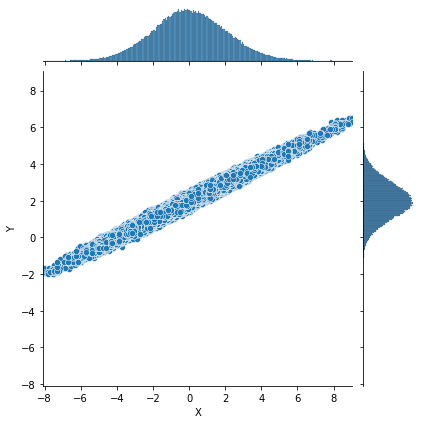

In [19]:
join_graph = sns.jointplot(data=df, x='X', y='Y')
join_graph.ax_marg_x.set_xlim(minimum_value, maximum_value)
join_graph.ax_marg_y.set_ylim(minimum_value, maximum_value)
plt.show()